In [24]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution
from preambules_list import preambule_list, Preambule
from Functions.preambule_variant import Correlation

from Functions.signal_generator import generate_ADSB, digitize_signal, normalize_signal, correlate_signals, signal_start_pause_length
from Functions.crc import generate_adsb_crc

#Configuration
amplitude = 1
data_bits = bytes([0x8D, 0x40, 0x6B, 0x90, 0x20, 0x15, 0xA6, 0x78, 0xD4, 0xD2, 0x20])
crc_bits = generate_adsb_crc(data_bits)
full_bits = data_bits + crc_bits
ideal_signal, filtered_signal, noisy_signal = generate_ADSB(amplitude, full_bits)
digitized_signal, digitized_t = digitize_signal(ideal_signal, 100E6, 10E6, 1.4, 2**10)
digitized_signal = normalize_signal(digitized_signal)

C:\Users\simon\AppData\Local\Temp\ipykernel_13772\669811488.py:53: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(


Result x:
0.54 0.12 0.08 -0.73 -0.00 0.30 0.49 0.42 -1.29 0.39 -0.18 -0.48 1.00 -0.11 0.41 0.29 -1.46 0.16 0.69 0.65 0.13 -0.33 -1.13 0.48 0.21 -0.28 0.71 -0.78 0.05 0.31 -0.46 -0.40 0.51 0.26 0.75 -0.64 -0.86 0.57 0.28 0.66 -0.23 -0.27 -0.43 0.16 0.13 0.05 0.09 -0.38 0.11 0.12 

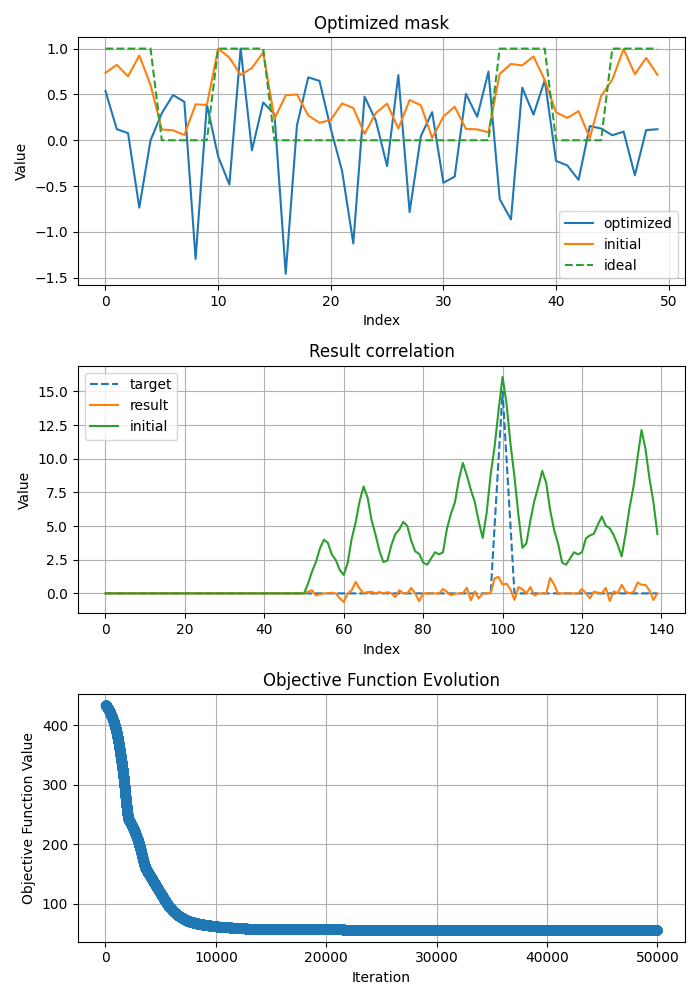

Optimization Result:
       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 55.10589456519029
             x: [ 4.331e-01  9.789e-02 ...  8.923e-02  9.756e-02]
           nit: 50000
          nfev: 57838
 final_simplex: (array([[ 4.331e-01,  9.789e-02, ...,  8.923e-02,
                         9.756e-02],
                       [ 4.329e-01,  9.802e-02, ...,  8.918e-02,
                         9.765e-02],
                       ...,
                       [ 4.329e-01,  9.774e-02, ...,  8.901e-02,
                         9.778e-02],
                       [ 4.330e-01,  9.774e-02, ...,  8.896e-02,
                         9.773e-02]]), array([ 5.511e+01,  5.511e+01, ...,  5.511e+01,  5.511e+01]))


In [83]:
preamble_enum = Preambule.Ideal
preamble = preambule_list[preamble_enum.value]

expected_maximum = preamble.get_expected_maximum() + signal_start_pause_length
full_signal_max = expected_maximum + 40

target = np.array(digitized_signal)[:full_signal_max]

initial_guess = np.random.uniform(0, 1, len(preamble.get_coefficients())) + preamble.get_coefficients()
initial_guess = normalize_signal(initial_guess)

target_impulse = [5, 10, 15, 10, 5]
target_impulse_side_length = int((len(target_impulse) - 1) / 2)
target_corr_left_size = expected_maximum - target_impulse_side_length
target_corr_right_size = full_signal_max - target_corr_left_size - len(target_impulse)
target_corr = np.concatenate((np.zeros(target_corr_left_size), target_impulse, np.zeros(target_corr_right_size)))

# Minimal noise (almost none)
# def objective_function(mask):
#     # target_noise = np.random.rand(len(target))/5000
#     # # target_noise = np.zeros(len(target))
#     # target_to_correlate = target + target_noise

#     correlation = correlate_signals(target, mask)
#     return -np.max(correlation)  # Maximize correlation by minimizing its negative


def find_diff_between_signals(sig1 : np.ndarray, sig2 : np.ndarray) -> int:
    assert len(sig1) == len(sig2), f"Signals must have the same length {len(sig1)} and {len(sig2)}"
    abs = np.abs(sig2 - sig1)
    sum = np.sum(abs)
    return sum

# With impulse characteristic
def objective_function(mask):
    # target_noise = np.random.rand(len(target))/500
    target_noise = np.zeros(len(target))
    target_to_correlate = target + target_noise

    correlation = correlate_signals(target_to_correlate, mask)
    diff_between_signals = find_diff_between_signals(correlation, target_corr)
    return diff_between_signals

class OptimizationTracker:
    def __init__(self):
        self.history = []

    def callback(self, xk):
        self.history.append(xk)

tracker = OptimizationTracker()

result = minimize(
    objective_function,
    initial_guess,
    method='Nelder-Mead',
    callback=tracker.callback,
    options={'disp': True, 'maxiter': 50000, 'adaptive': True}
    # options={'disp': True, 'adaptive': True}
)

# bounds = [(-1, 1)] * len(initial_guess)
# result = minimize(
#     objective_function,
#     initial_guess,
#     args=(),
#     method='BFGS',
#     callback=tracker.callback,
#     bounds=bounds,
#     constraints=None,
#     options={'disp': True, 'maxiter': 1000}
# )

result_mask = (result.x)/max(result.x)
print("Result x:")
[print(f"{x:.2f}", end =" ") for x in result_mask]

# Extract data for plotting
history = np.array(tracker.history)
z_vals = np.array([objective_function(x) for x in history])

result_corr = correlate_signals(target, result_mask)
initial_corr = correlate_signals(target, initial_guess)

# Plot evolution of the objective function
plt.figure(figsize=(7, 10))
plt.subplot(311)
plt.plot(result_mask, label="optimized")
plt.plot(initial_guess, label="initial")
plt.plot(preamble.get_coefficients(), '--', label = "ideal")
plt.title("Optimized mask")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.subplot(312)
plt.title("Result correlation")
plt.xlabel("Index")
plt.ylabel("Value")
plt.plot(target_corr, '--', label = "target")
plt.plot(result_corr, label = "result")
plt.plot(initial_corr, label = "initial")
plt.legend()
plt.grid()
plt.subplot(313)
plt.plot(z_vals, marker='o')
plt.title("Objective Function Evolution")
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.grid()
plt.tight_layout()
plt.show()

# Print optimization results
print("Optimization Result:")
print(result)

# TODO: siekti kad koreliacijos rezultatas atitinku vienetini impulsa
# TODO: atimti korelaicijos rezultata is vienetinio impulso ir isimti moduli kad siektu 0
# TODO: arba visa arba maziau duoti atskaitu
